# RAG From scratch: Indexing


## Environment

`(1) Packages`

In [ ]:
!pip install langchain_community langchain_openai langchainhub langchain -q
!pip install tiktoken chromadb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 16.3 MB/s eta 0:00:00

`(2) LangSmith`

In [ ]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [ ]:
api_key = os.getenv("LANGCHAIN_API_KEY")
if api_key:
    os.environ["LANGCHAIN_API_KEY"] = api_key
else:
    api_key = input("Enter your API key: ")
    os.environ["LANGCHAIN_API_KEY"] = api_key

`(3) API Keys`

In [ ]:
api_key = os.getenv("OPENAI_API_KEY")
if api_key:
    os.environ["OPENAI_API_KEY"] = api_key
    api_key = input("Enter your API key: ")
    os.environ["OPENAI_API_KEY"] = api_key
else:
    api_key = input("Enter your API key: ")
    os.environ["OPENAI_API_KEY"] = api_key

## Multi-representation Indexing

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

In [ ]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

chain = (
    {
        "doc": lambda x: x.page_content
    }
    | ChatPromptTemplate.from_template("Summarize the following document: \n\n{doc}")
    | ChatOpenAI(model="gpt-3.5-turbo", max_retries=0,)
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})

In [ ]:
from langchain.storage import InMemoryByteStore
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever


In [ ]:
## The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="summaries",
    embedding_function=OpenAIEmbeddings()
)

# The storage layer for the parent document
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(
        page_content=s,
        metadata={id_key: doc_ids[i]}
    )
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

<ipython-input-8-2268ebd681be>:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [ ]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query, k=1)
sub_docs[0]

Document(metadata={'doc_id': '18bb9dd1-6268-43fd-bf52-5f7b172e66d8'}, page_content='The document discusses the concept of building autonomous agents powered by LLM (large language model) as the core controller, with proof-of-concept demos like AutoGPT, GPT-Engineer, and BabyAGI. It covers components such as planning, memory, and tool use in these agents, along with case studies like the Scientific Discovery Agent and Generative Agents Simulation. Challenges like the finite context length, natural language interface reliability, and long-term planning are highlighted. The document also includes references to related research papers and frameworks in the field.')

In [ ]:
retrieved_docs = retriever.get_relevant_documents(query, n_results=1)
retrieved_docs[0].page_content[0:500]

<ipython-input-10-47307b85c41e>:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query, n_results=1)


"\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS"

## RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval

- Embed each document + build a document tree (RAPTOR)

- Intuition:
    - Cluster and summarize similar docs
    - Capture information from related documents into a summary
    - Can help on question that need context from a few places answer

- Scales to large context

In [ ]:
!pip install -U langchain umap-learn scikit-learn langchain_community tiktoken langchain-openai langchainhub langchain-chroma langchain-anthropic -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.9/207.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 79.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.47.1 requires tokenizers<0.22,>=0.21, but you have tokenizers 0.20.3 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

In [ ]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# LCEL docs
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url,
    max_depth=30,
    extractor=lambda x: Soup(x, "html.parser").text,
)
docs = loader.load()

In [ ]:
# LCEL w/ PydanticOutputParser (ouside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

In [ ]:
# LCEL w/ Self Query (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

In [ ]:
# Doc texts
docs.extend([*docs_pydantic, *docs_sq])
docs_texts = [d.page_content for d in docs]

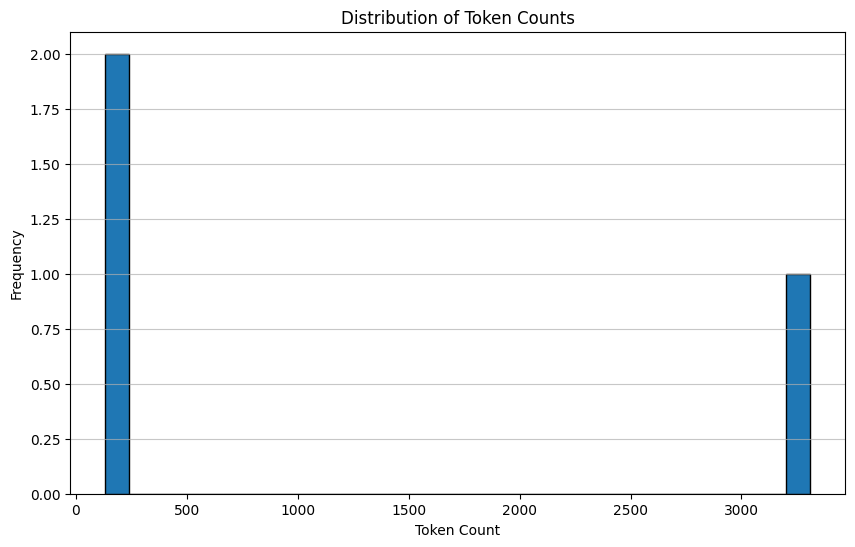

In [ ]:
# Calculate the number of tokens
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, edgecolor='black')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Counts')
plt.grid(axis="y", alpha=0.7)
plt.show()

In [ ]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reverted = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [d.page_content for d in d_reverted]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 3308


In [ ]:
embd = OpenAIEmbeddings()
model = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

### Tree Construction

The clustering apporach in tree construction includes a few interesting ideas.

- GMM (Gaussian Mixture Model):
    - Model the distribution of data points across different clusters
    - Optimal number of clusters by evaluating the model's Bayesian Information Criterion (BIC)

- UMAP (Uniform Manifold Approximation and Projection)
    - Supports clustering
    - Reduces the dimensionality of high-dimensional data
    - UMAP helps to highlight the natural grouping of data points based on their similarities

- Local and Global Clustering
    - Used to analyze data at different scales
    - Both fine-grained and broader patterns within the data are captured effectively

- Thresholding
    - Apply in the context of GMM to determine cluster membership
    - Based on the probability distribution (assignment of data points to >= 1 cluster)

In [ ]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 42

def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str= "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; The number of neighbors to consider for each point.
        if not provided, it defaults to the square root of the number of embeeding
    - metric: The distance metric to use for UMAP

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality
    """

    if n_neighbors is None:
        n_neighbors = int((len(embedings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=dim,
        metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    num_neighbors: int=10,
    metric: str= "cosine",
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after
    global clustering

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point
    - metric: The distance metric to use for UMAP

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality
    """
    return umap.UMAP(
        n_neighbors=num_neighbors,
        n_components=dim,
        metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray,
    max_clusters: int=50,
    random_state: int= RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the
    Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array
    - max_clusters: The maximum number of clusters to consider
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(
            n_components=n,
            random_state=random_state
        )
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(
    embeddings: np.ndarray,
    threshold: float,
    random_state: int=0
):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a
    probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability thershold for assigning an embedding to a cluster
    - random_state: Seed for reproducibility

    Returns:
    - A tuple containing the cluster labels and the number of cluster determined
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(
        n_components=n_clusters,
        random_state=random_state
    )
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing  their dimensionality
    globally, then clustering using a Gaussian Mixture, and finally performing
    local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for GMM clustering.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim +1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)

    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global,
        threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract enbeddubgs belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings) == 0:
            continue
        if len(global_cluster_embeddings) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_,
                dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local,
                threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]

            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

            total_clusters += n__local_clusters

    return all_local_clusters


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd`object with a method
    `embed_document` that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with
    texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step.
    It assumes the existence of a previously defined `perform_clustering` function
    that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings,
    and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts) # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np,
        dim=10,
        threshold=0.1
    ) # Perform clustering on the embeddings
    df = pd.DataFrame()
    df["text"] = texts
    df["embeddings"] = text_embeddings_np.tolist()
    df["cluster"] = cluster_labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- \n".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates
    embeddings for the texts, clusters them based on similarity, expands the cluster
    assignments for easier processing, and then summarizes the content
    within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of procesing.

    Returns:
    - Tuple containing two DataFrames:
        1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings,
        and cluster assignments.
        2. The second DataFrame (`df_summaries`) contains summaries for each cluster, the specified level
        of detail, and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text, 'embd', and 'cluster' column
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straighforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {
                    "text": row["text"],
                    "embeddings": row["embeddings"],
                    "cluster": cluster,
                }
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()
    print(f"--Generated {len(all_clusters)} clusters --")

    # Summarization
    template = """
    Here is a sub-set of LangChain Expression Language doc.

    LangChain Expression Language provides a way to compose chain in LangChain.

    Give a detailed summary of the documentation provided.

    Documentation:
    {context}
    """

    prompt = ChatPromptTemplate.from_template(template)
    chain = (
        prompt
        | model
        | StrOutputParser()
    )

    # Format text withing each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({
            "context": formatted_txt
        }))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int=1, n_levels: int=3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarize texts up to a specified
    level or until the number of unique clusters becomes 1, storing the
    results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys
    are the recurssion levels and values are tuples containing the clusters
    DataFrame and the summaries DataFrame.
    """

    results = {}

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recurssion
        next_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            next_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [ ]:
## Build tree
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_text, level=1, n_levels=3)

--Generated 1 clusters --


The paper reports best performance from `collapsed tree retrieval`.

This involves flattening the tree sctructure into a single layer and then applying a k-nearest neighbors (kNN) search across all nodes simultaneously.

In [ ]:
from langchain_chroma import Chroma

# Initialize all texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract
# summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extended all_texts with the summaries from the current level
    all_texts.extend(summaries)

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

Now we can use our flattened, indexed tree in a RAG chain.

In [ ]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    }
    | prompt
    | model
    | StrOutputParser()
)

# Question
rag_chain.invoke(
    "How to define a RAG chain? Give me a specific code example"
)

'A RAG chain is defined in LangChain using the LangChain Expression Language (LCEL) by composing existing Runnables together, primarily using primitives like RunnableSequence and RunnableParallel. Here is a specific code example: chain = RunnableSequence([runnable1, runnable2]) for RunnableSequence and chain = RunnableParallel({"key1": runnable1, "key2": runnable2}) for RunnableParallel. The shorthand syntax for composition in LCEL includes the | operator and .pipe method, with automatic type coercion for dictionaries and functions.'

## ColBERT

RAGatouille makes it as simple to use ColBERT.

ColBERT generates a contextually influenced vector for each token in passages.

ColBERT similarly generates vector for each token in the query.

Then, the score of each document is the sum of the maximum similarity of each query embedding to any of the document embedings

In [ ]:
!pip install -U ragatouille -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.0/493.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━

In [ ]:
from ragatouille import RAGPretrainedModel

RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[Jan 15, 14:18:21] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
import requests

def get_wikipedia_page(title: str):
    """
    Retriever the full text content of a Wikipedia page.

    Parameters
    - param title: str - The title of the Wikipedia page to retrieve.

    Returns
    - str - The full text content of the Wikipedia page.
    """

    # Wikipedia API endpoint
    URL = "https://en.wikipedia.org/w/api.php"

    # Parameters for the API requests
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }

    # Custom User-Agent header to comply with Wikipedia's best practices
    headers = {
        "User-Agent": "RAGatouille_tutorial/0.0.1 (ben@clavie.eu)"
    }

    response = requests.get(URL, params=params, headers=headers)
    data = response.json()

    # Extracting page content
    page = next(iter(data["query"]["pages"].values()))
    page_content = page["extract"] if "extract" in page else None
    return page_content

full_document = get_wikipedia_page("Hayao_Miyazaki")

In [ ]:
RAG.index(
    collection=[full_document],
    index_name="Miyazaki-123",
    max_document_length=180,
    split_documents=True
)

---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Jan 15, 14:27:40] #> Creating directory .ragatouille/colbert/indexes/Miyazaki-123 


[Jan 15, 14:27:41] [0] 		 #> Encoding 122 passages..


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 4/4 [01:25<00:00, 21.42s/it]

[Jan 15, 14:29:07] [0] 		 avg_doclen_est = 131.80328369140625 	 len(local_sample) = 122
[Jan 15, 14:29:07] [0] 		 Creating 1,024 partitions.
[Jan 15, 14:29:07] [0] 		 *Estimated* 16,080 embeddings.
[Jan 15, 14:29:07] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/Miyazaki-123/plan.json ..



/usr/local/lib/python3.10/dist-packages/colbert/indexing/collection_indexer.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sub_sample = torch.load(sub_sample_path)
/

used 20 iterations (7.7827s) to cluster 15276 items into 1024 clusters
[0.04, 0.041, 0.041, 0.036, 0.033, 0.037, 0.036, 0.036, 0.034, 0.036, 0.035, 0.036, 0.036, 0.039, 0.035, 0.038, 0.033, 0.035, 0.035, 0.038, 0.035, 0.035, 0.037, 0.039, 0.038, 0.034, 0.041, 0.036, 0.035, 0.037, 0.036, 0.04, 0.04, 0.037, 0.037, 0.034, 0.039, 0.036, 0.037, 0.04, 0.037, 0.039, 0.035, 0.034, 0.035, 0.034, 0.034, 0.039, 0.037, 0.034, 0.034, 0.034, 0.036, 0.037, 0.036, 0.037, 0.038, 0.038, 0.042, 0.034, 0.037, 0.037, 0.034, 0.037, 0.039, 0.037, 0.037, 0.039, 0.031, 0.035, 0.034, 0.035, 0.036, 0.037, 0.037, 0.037, 0.034, 0.04, 0.035, 0.036, 0.036, 0.038, 0.035, 0.039, 0.033, 0.036, 0.039, 0.039, 0.034, 0.044, 0.036, 0.038, 0.036, 0.035, 0.038, 0.038, 0.039, 0.036, 0.038, 0.036, 0.04, 0.041, 0.037, 0.036, 0.036, 0.035, 0.037, 0.034, 0.038, 0.033, 0.037, 0.037, 0.035, 0.033, 0.037, 0.036, 0.037, 0.038, 0.037, 0.04, 0.033, 0.034, 0.035, 0.036, 0.034, 0.037, 0.035, 0.038]


0it [00:00, ?it/s]

[Jan 15, 14:29:15] [0] 		 #> Encoding 122 passages..



100%|██████████| 4/4 [01:19<00:00, 19.96s/it]
1it [01:20, 80.22s/it]
  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an 

[Jan 15, 14:30:35] #> Optimizing IVF to store map from centroids to list of pids..
[Jan 15, 14:30:35] #> Building the emb2pid mapping..
[Jan 15, 14:30:35] len(emb2pid) = 16080



100%|██████████| 1024/1024 [00:00<00:00, 38790.90it/s]

[Jan 15, 14:30:35] #> Saved optimized IVF to .ragatouille/colbert/indexes/Miyazaki-123/ivf.pid.pt
Done indexing!


'.ragatouille/colbert/indexes/Miyazaki-123'

In [ ]:
results = RAG.search(query="What animation studio did Miyazaki found?", k=3)
results

Loading searcher for index Miyazaki-123 for the first time... This may take a few seconds
[Jan 15, 14:30:41] #> Loading codec...
[Jan 15, 14:30:41] #> Loading IVF...
[Jan 15, 14:30:41] Loading segmented_lookup_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitra

[Jan 15, 14:31:16] #> Loading doclens...


100%|██████████| 1/1 [00:00<00:00, 3160.74it/s]

[Jan 15, 14:31:17] #> Loading codes and residuals...



  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


[Jan 15, 14:31:17] Loading filter_pids_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


[Jan 15, 14:31:49] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . What animation studio did Miyazaki found?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  7284,  2996,  2106,  2771,  3148, 18637,  2179,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])



/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[{'content': '=== Studio Ghibli ===\n\n\n==== Early films (1985–1995) ====\nFollowing the success of Nausicaä of the Valley of the Wind, Miyazaki and Takahata founded the animation production company Studio Ghibli on June 15, 1985, as a subsidiary of Tokuma Shoten, with offices in Kichijōji designed by Miyazaki. Miyazaki named the studio after the Caproni Ca.309 and the Italian word meaning "a hot wind that blows in the desert"; the name had been registered a year earlier.',
  'score': 25.89379119873047,
  'rank': 1,
  'document_id': '6eda9ec6-ac39-4829-bf41-76ac3f555711',
  'passage_id': 42},
 {'content': 'Hayao Miyazaki (宮崎 駿 or 宮﨑 駿, Miyazaki Hayao, [mijaꜜzaki hajao]; born January 5, 1941) is a Japanese animator, filmmaker, and manga artist. He co-founded Studio Ghibli and serves as its honorary chairman. Over the course of his career, Miyazaki has attained international acclaim as a masterful storyteller and creator of Japanese animated feature films, and is widely regarded as one 

In [ ]:
retriever = RAG.as_langchain_retriever(k=3)
retriever.invoke(
    "What animation studio did Miyazaki found?"
)

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[Document(metadata={}, page_content='=== Studio Ghibli ===\n\n\n==== Early films (1985–1995) ====\nFollowing the success of Nausicaä of the Valley of the Wind, Miyazaki and Takahata founded the animation production company Studio Ghibli on June 15, 1985, as a subsidiary of Tokuma Shoten, with offices in Kichijōji designed by Miyazaki. Miyazaki named the studio after the Caproni Ca.309 and the Italian word meaning "a hot wind that blows in the desert"; the name had been registered a year earlier.'),
 Document(metadata={}, page_content='Hayao Miyazaki (宮崎 駿 or 宮﨑 駿, Miyazaki Hayao, [mijaꜜzaki hajao]; born January 5, 1941) is a Japanese animator, filmmaker, and manga artist. He co-founded Studio Ghibli and serves as its honorary chairman. Over the course of his career, Miyazaki has attained international acclaim as a masterful storyteller and creator of Japanese animated feature films, and is widely regarded as one of the most accomplished filmmakers in the history of animation.\nBorn in 